In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Field Generation

(np.float64(0.0), np.float64(100.0), np.float64(0.0), np.float64(100.0))

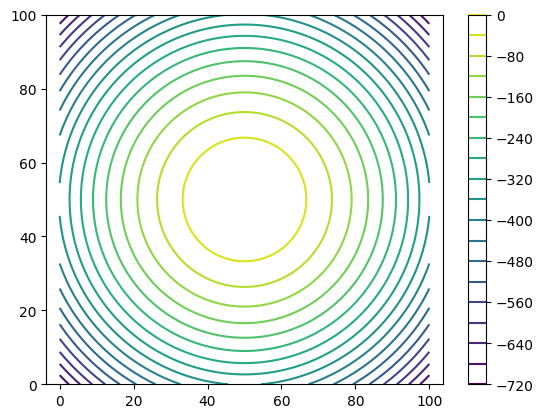

In [2]:
width=500

x_circ = np.linspace(-width // 2, width // 2, 101)  
y_circ = np.linspace(-width // 2, width // 2, 101)
X_circ, Y_circ = np.meshgrid(x_circ, y_circ)

x0_circ, y0_circ = 0, 0

A_circ = -2/350
Psi_circ = A_circ*( (X_circ-x0_circ)**2 + (Y_circ-y0_circ)**2 )

u_circ, v_circ = (-2*A_circ*(Y_circ - y0_circ)).T, (2*A_circ*(X_circ - x0_circ)).T

plt.contour(Psi_circ, 20)
plt.colorbar()
plt.axis('equal')



(np.float64(-250.0), np.float64(250.0), np.float64(-250.0), np.float64(250.0))

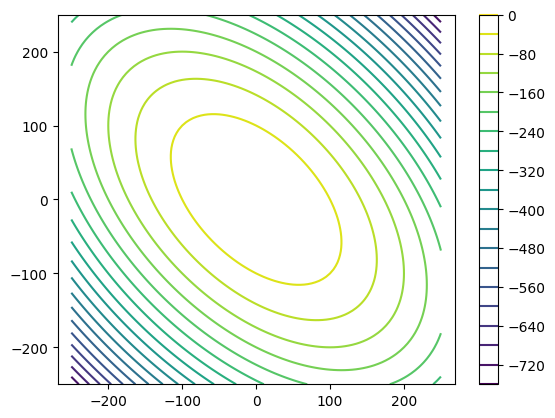

In [3]:
width=500

x_ell = np.linspace(-width // 2, width // 2, 101)  
y_ell = np.linspace(-width // 2, width // 2, 101) 
X_ell, Y_ell = np.meshgrid(x_ell, y_ell)

x0_ell, y0_ell = 0, 0

q11, q22, q12 = 2, 2, 1
A_ell = -1/500
q11 *= A_ell
q22 *= A_ell
q12 *= A_ell
Q = np.array([[q11, q12], [q12, q22]])

XY = np.stack((X_ell, Y_ell), axis=-1)  # Shape (101, 101, 2)
Psi_ell = np.einsum("...i,ij,...j->...", XY, Q, XY)

u_ell = (-2*q22*(Y_ell-y0_ell) - 2*q12*(X_ell-x0_ell)).T
v_ell =  (2*q11*(X_ell-x0_ell) + 2*q12*(Y_ell-y0_ell)).T

plt.contour(X_ell, Y_ell, Psi_ell, 20)
plt.colorbar()
plt.axis('equal')

## MOCA1

In [4]:
def moca1(u, v, x, y, n_ic, n_jc, r=20):
    u1 = u[n_ic-r:n_ic+r+1, n_jc]
    v1 = v[n_ic-r:n_ic+r+1, n_jc]
    dx = x[1] - x[0]
    xx = x[n_ic-r:n_ic+r+1]
    yy = [y[n_jc]] * len(xx)
    l = xx - xx[0]
    coefficients = np.polyfit(l, v1, 1)
    c, b = coefficients
    a = np.polyfit(l, u1, 0)[0]
    x0 = - b / c
    y0 = a / c
    x0 += xx[0]
    y0 += yy[0]

    return x0, y0, l, xx, yy, u1, v1, a, b, c

#### Circle

(np.float64(-252.5), np.float64(252.5), np.float64(-252.5), np.float64(252.5))

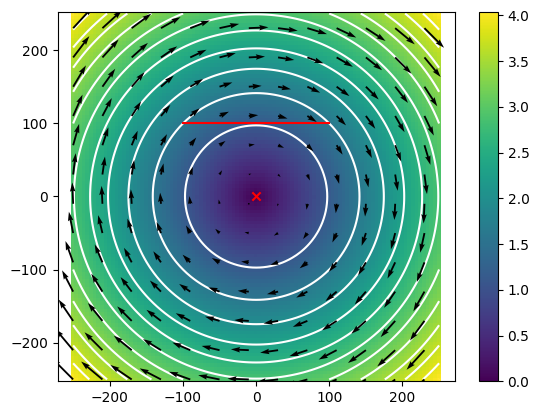

In [5]:
nic = 50
njc = 70

x0_circ, y0_circ, l_circ, xx_circ, yy_circ, u1_circ, v1_circ, a_circ, b_circ, c_circ = moca1(u_circ, v_circ, x_circ, y_circ, nic, njc)

plt.pcolor(X_circ, Y_circ, np.hypot(u_circ, v_circ).T)
plt.colorbar()

levels = range(int(np.min(Psi_circ)), int(np.max(Psi_circ)), 60)
plt.contour(X_circ, Y_circ, Psi_circ, levels=levels, colors='w', linestyles='-')

spacing = 8
plt.quiver(X_circ[::spacing, ::spacing], Y_circ[::spacing, ::spacing],
            u_circ[::spacing, ::spacing].T, v_circ[::spacing, ::spacing].T, zorder=3)

plt.plot(xx_circ, yy_circ, 'r')

plt.scatter(x0_circ, y0_circ, color='r', marker='x')

plt.axis('equal')

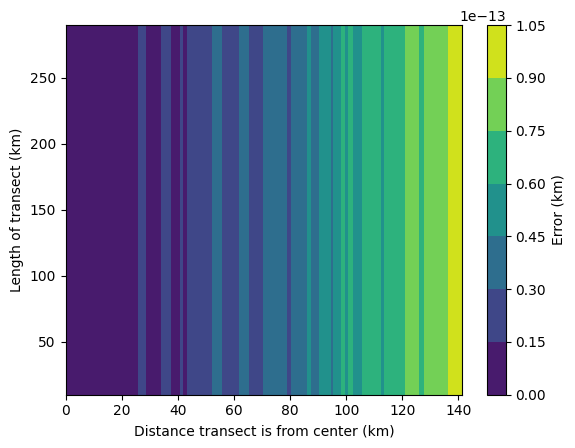

In [6]:
df_circ = pd.DataFrame(columns=['D', 'L', 'Error'])
r_max = 30
for i in range(u_circ.shape[0]//2, u_circ.shape[0] - r_max + 1, 2):
    for j in range(u_circ.shape[1]//2, u_circ.shape[1] - r_max + 1, 2):
        d = np.hypot(X_circ[i,j], Y_circ[i,j])
        for r in range(1, r_max + 1, 2):
            x0_test, y0_test, _, _, _, _, _, _, _, _ = moca1(u_circ, v_circ, x_circ, y_circ, i, j)
            err = np.hypot(x0_test, y0_test)
            dx = x_circ[1]-x_circ[0]
            df_circ.loc[len(df_circ)] = {'D': d, 'L': 2*r*dx, 'Error': err}
df_agg_circ = df_circ.groupby(['D', 'L'], as_index=False)['Error'].mean().copy()

D_circ = np.unique(df_agg_circ['D'])
L_circ = np.unique(df_agg_circ['L'])

# Create grid and reshape error values
D_circ, L_circ = np.meshgrid(D_circ, L_circ)
Z_circ = df_agg_circ.pivot(index='L', columns='D', values='Error').values

plt.contourf(D_circ, L_circ, Z_circ)
plt.colorbar(label='Error (km)')
plt.xlabel('Distance transect is from center (km)')
plt.ylabel('Length of transect (km)')
plt.show()



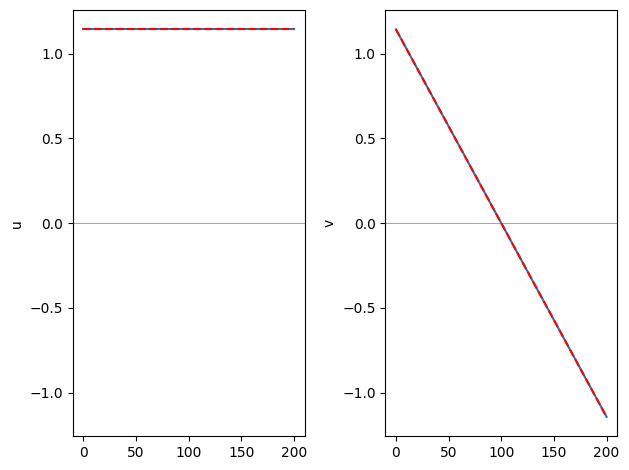

In [7]:
fig, axs = plt.subplots(1, 2)

for ax, data, ylabel, p in zip(axs, [u1_circ, v1_circ], ['u', 'v'], [0, 1]):
    ax.plot(l_circ, data)
    ax.plot(l_circ, np.poly1d(np.polyfit(l_circ, data, p))(l_circ), "--r")
    ax.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
    ax.set_ylabel(ylabel)

ymin, ymax = min(ax.get_ylim()[0] for ax in axs), max(ax.get_ylim()[1] for ax in axs)
for ax in axs:
    ax.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()

#### Ellipse

-50.000000000000014 -7.105427357601002e-14


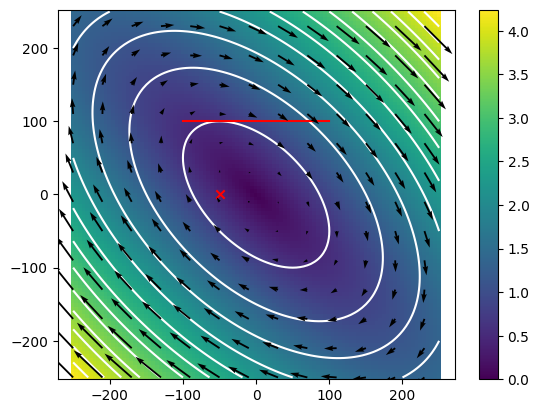

In [8]:
x0_ell, y0_ell, l_ell, xx_ell, yy_ell, u1_ell, v1_ell, a_ell, b_ell, c_ell = moca1(u_ell, v_ell, x_ell, y_ell, nic, njc)

plt.pcolor(X_ell, Y_ell, np.hypot(u_ell, v_ell).T)
plt.colorbar()

levels = range(int(np.min(Psi_ell)), int(np.max(Psi_ell)), 60)
plt.contour(X_ell, Y_ell, Psi_ell, levels=levels, colors='w', linestyles='-')

spacing = 8
plt.quiver(X_ell[::spacing, ::spacing], Y_ell[::spacing, ::spacing], u_ell[::spacing, ::spacing].T, v_ell[::spacing, ::spacing].T, zorder=3)

plt.plot(xx_ell, yy_ell, 'r')
plt.scatter(x0_ell, y0_ell, color='r', marker='x')

plt.axis('equal')

print(x0_ell, y0_ell)

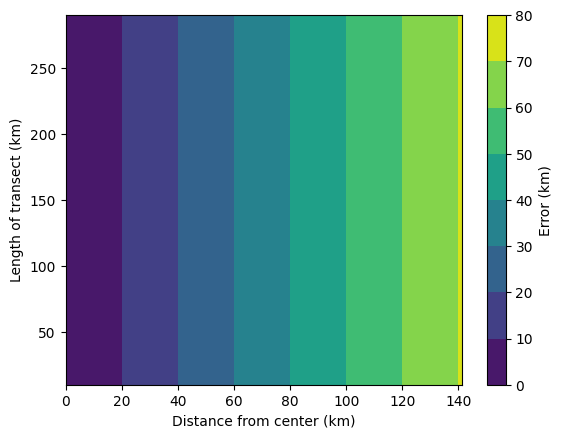

In [9]:
df_ell = pd.DataFrame(columns=['D', 'L', 'Error'])
r_max = 30
for i in range(r_max, u_ell.shape[0] - r_max + 1, 2):
    for j in range(u_ell.shape[1]//2, u_ell.shape[1] - r_max + 1, 2):
        d = np.hypot(X_ell[i,j], Y_ell[i,j])
        for r in range(1, r_max + 1, 2):
            x0_test, y0_test, _, _, _, _, _, _, _, _ = moca1(u_ell, v_ell, x_ell, y_ell, i, j)
            err = np.hypot(x0_test, y0_test)
            dx = x_ell[1]-x_ell[0]
            df_ell.loc[len(df_ell)] = {'D': d, 'L': 2*r*dx, 'Error': err}

df_agg_ell = df_ell.groupby(['D', 'L'], as_index=False)['Error'].mean().copy()

D_ell = np.unique(df_agg_ell['D'])
L_ell = np.unique(df_agg_ell['L'])

# Create grid and reshape error values
D_ell, L_ell = np.meshgrid(D_ell, L_ell)
Z_ell = df_agg_ell.pivot(index='L', columns='D', values='Error').values

plt.contourf(D_ell, L_ell, Z_ell)
plt.colorbar(label='Error (km)')
plt.xlabel('Distance from center (km)')
plt.ylabel('Length of transect (km)')
plt.show()

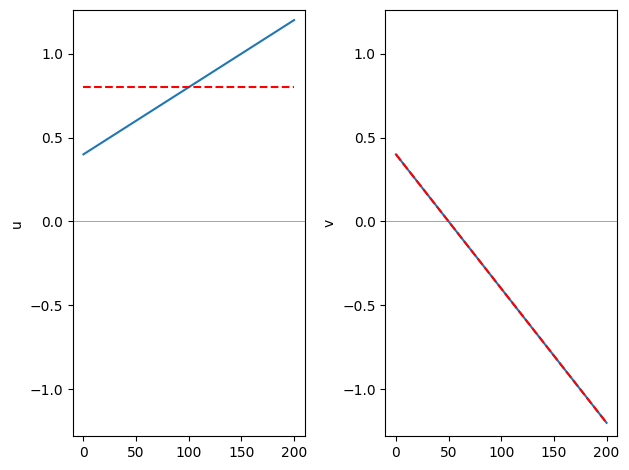

In [10]:
fig, axs = plt.subplots(1, 2)

for ax, data, ylabel, p in zip(axs, [u1_ell, v1_ell], ['u', 'v'], [0, 1]):
    ax.plot(l_ell, data)
    ax.plot(l_ell, np.poly1d(np.polyfit(l_ell, data, p))(l_ell), "--r")
    ax.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
    ax.set_ylabel(ylabel)

ymin, ymax = min(ax.get_ylim()[0] for ax in axs), max(ax.get_ylim()[1] for ax in axs)
for ax in axs:
    ax.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()

#### Paper Plot

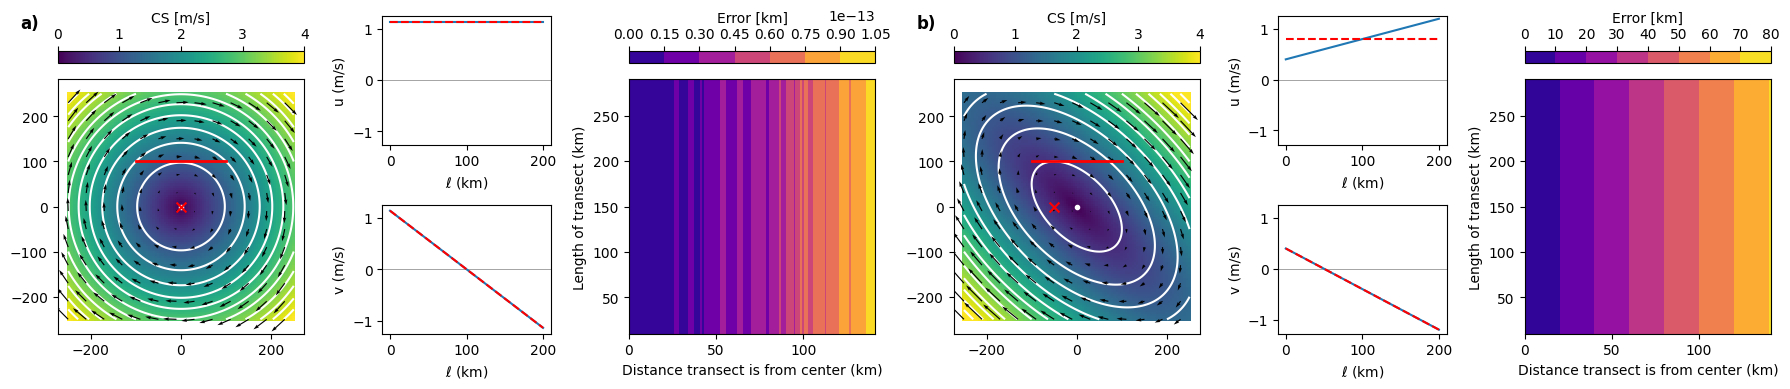

In [11]:
import matplotlib.gridspec as gridspec


fig = plt.figure(figsize=(18, 4))
spacing = 8
gs = gridspec.GridSpec(2, 10, figure=fig, width_ratios=[1, 1, 2, 1, 1, 1, 1, 2, 1, 1])  # Adjust width ratios

# LEFT PLOT (PLOT A)
ax_main_left = fig.add_subplot(gs[:, :2])
pcm = ax_main_left.pcolor(X_circ, Y_circ, np.hypot(u_circ, v_circ).T, vmin=0, vmax=4)
cbar = fig.colorbar(pcm, ax=ax_main_left, orientation='horizontal', location='top', label='CS [m/s]')
levels = range(int(np.min(Psi_circ)), int(np.max(Psi_circ)), 60)
ax_main_left.contour(X_circ, Y_circ, Psi_circ, levels=levels, colors='w', linestyles='-')
ax_main_left.quiver(X_circ[::spacing, ::spacing], Y_circ[::spacing, ::spacing],
            u_circ[::spacing, ::spacing].T, v_circ[::spacing, ::spacing].T, zorder=3)
ax_main_left.plot(xx_circ, yy_circ, 'r', linewidth=2, zorder=3)
ax_main_left.scatter(0, 0, color='w', marker='.')
ax_main_left.scatter(x0_circ, y0_circ, color='r', marker='x', s=50, zorder=4)
ax_main_left.axis('equal')
ax_main_left.text(-0.15, 1.20, 'a)', transform=ax_main_left.transAxes, fontsize=12, fontweight='bold')

# Subplot columns (2x1 on the right)
ax2_left = fig.add_subplot(gs[0, 2])
ax3_left = fig.add_subplot(gs[1, 2])

axs = [ax2_left, ax3_left]
for ax, data, ylabel, p in zip(axs, [u1_circ, v1_circ], ['u (m/s)', 'v (m/s)'], [0, 1]):
    ax.plot(l_circ, data)
    ax.plot(l_circ, np.poly1d(np.polyfit(l_circ, data, p))(l_circ), "--r")
    ax.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(r'$\ell$ (km)')
ymin, ymax = min(ax.get_ylim()[0] for ax in axs), max(ax.get_ylim()[1] for ax in axs)
for ax in axs:
    ax.set_ylim(ymin, ymax)

# Left error 
ax_error_left = fig.add_subplot(gs[:, 3:5])
ctf = ax_error_left.contourf(D_circ, L_circ, Z_circ, cmap='plasma')
cbar = fig.colorbar(ctf, ax=ax_error_left, orientation='horizontal', location='top', label='Error [km]')
ax_error_left.set_xlabel('Distance transect is from center (km)')
ax_error_left.set_ylabel('Length of transect (km)')

# RIGHT PLOT (PLOT B)
ax_main_right = fig.add_subplot(gs[:, 5:7])
pcm = ax_main_right.pcolor(X_ell, Y_ell, np.hypot(u_ell, v_ell).T, vmin=0, vmax=4)
cbar = fig.colorbar(pcm, ax=ax_main_right, orientation='horizontal', location='top', label='CS [m/s]')
levels = range(int(np.min(Psi_ell)), int(np.max(Psi_ell)), 60)
ax_main_right.contour(X_ell, Y_ell, Psi_ell, levels=levels, colors='w', linestyles='-')
ax_main_right.quiver(X_ell[::spacing, ::spacing], Y_ell[::spacing, ::spacing],
             u_ell[::spacing, ::spacing].T, v_ell[::spacing, ::spacing].T, zorder=3)
ax_main_right.plot(xx_ell, yy_ell, 'r', linewidth=2, zorder=3)
ax_main_right.scatter(0, 0, color='w', marker='.')
ax_main_right.scatter(x0_ell, y0_ell, color='r', marker='x', s=50, zorder=4)
ax_main_right.axis('equal')
ax_main_right.text(-0.15, 1.20, 'b)', transform=ax_main_right.transAxes, fontsize=12, fontweight='bold')

# Subplot columns (2x1 on the right)
ax2_right = fig.add_subplot(gs[0, 7])
ax3_right = fig.add_subplot(gs[1, 7])

axs = [ax2_right, ax3_right]
for ax, data, ylabel, p in zip(axs, [u1_ell, v1_ell], ['u (m/s)', 'v (m/s)'], [0, 1]):
    ax.plot(l_ell, data)
    ax.plot(l_ell, np.poly1d(np.polyfit(l_ell, data, p))(l_ell), "--r")
    ax.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(r'$\ell$ (km)')
ymin, ymax = min(ax.get_ylim()[0] for ax in axs), max(ax.get_ylim()[1] for ax in axs)
for ax in axs:
    ax.set_ylim(ymin, ymax)

# Right error 
ax_error_right = fig.add_subplot(gs[:, 8:10])
ctf = ax_error_right.contourf(D_ell, L_ell, Z_ell, cmap='plasma')
cbar = fig.colorbar(ctf, ax=ax_error_right, orientation='horizontal', location='top', label='Error [km]')
ax_error_right.set_xlabel('Distance transect is from center (km)')
ax_error_right.set_ylabel('Length of transect (km)')

plt.tight_layout()
plt.show()

## MOCA2

In [12]:
def moca2(nic, njc, r, u, v, X, Y):
    u1, v1 = u[nic-r:nic+r+1, njc], v[nic-r:nic+r+1, njc]
    x1, y1 = X.T[nic-r:nic+r+1, njc], Y.T[nic-r:nic+r+1, njc]
    xx = x1 - X.T[nic, njc]

    u2, v2 = u[nic, njc-r:njc+r+1], v[nic, njc-r:njc+r+1]
    x2, y2 = X.T[nic, njc-r:njc+r+1], Y.T[nic, njc-r:njc+r+1]
    yy = y2 - Y.T[nic, njc]

    def lin_fit(x, y):
        p = np.polyfit(x, y, 1)
        y_pred = np.polyval(p, x)
        ss_tot, ss_res = np.sum((y - np.mean(y))**2), np.sum((y - y_pred)**2)
        r2 = 1.0 if ss_tot == 0 else 1 - ss_res / ss_tot
        return p[0], p[1], r2

    A1, A0, r2A = lin_fit(xx, u1)
    B1, B0, r2B = lin_fit(xx, v1)
    C1, C0, r2C = lin_fit(yy, u2)
    D1, D0, r2D = lin_fit(yy, v2)

    alpha = A0 if r2A < r2B else C0
    beta = B0 if r2B < r2D else D0
    gamma = A1 if r2A < r2D else -D1
    q11, q12, q22 = B1 / 2, -gamma / 2, -C1 / 2


    x0 = - ( alpha*gamma + beta*C1  ) / (C1*B1+gamma**2)
    y0 = ( beta*gamma-alpha*B1  ) / (C1*B1+gamma**2)
    # x0 = (alpha * q12 + beta * q22) / (2 * (q12**2 - q11 * q22))
    # y0 = (q11 * alpha + q12 * beta) / (2 * (q11 * q22 - q12**2))
    w = 2 * (q11 + q22)

    return x0 + X.T[nic, njc], y0 + Y.T[nic, njc], w

#### Circle

In [13]:
nic = 65
njc = 65

r = 20

u1_circ2 = u_circ[nic-r:nic+r+1, njc]
v1_circ2 = v_circ[nic-r:nic+r+1, njc]

x1_circ2 = X_circ.T[nic-r:nic+r+1, njc]
y1_circ2 = Y_circ.T[nic-r:nic+r+1, njc]

xx_circ2 = x1_circ2 - X_circ.T[nic, njc]

u2_circ2 = u_circ[nic, njc-r:njc+r+1]
v2_circ2 = v_circ[nic, njc-r:njc+r+1]

x2_circ2 = X_circ.T[nic, njc-r:njc+r+1]
y2_circ2 = Y_circ.T[nic, njc-r:njc+r+1]

yy_circ2 = y2_circ2 - Y_circ.T[nic, njc]

def lin_fit(x, y):
    p = np.polyfit(x, y, 1)
    y_pred = np.polyval(p, x)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    ss_res = np.sum((y - y_pred) ** 2)
    r2 = 1.0 if ss_tot == 0 else 1 - ss_res / ss_tot
    return p[0], p[1], r2

A1, A0, r2A = lin_fit(xx_circ2, u1_circ2)
B1, B0, r2B = lin_fit(xx_circ2, v1_circ2)
C1, C0, r2C = lin_fit(yy_circ2, u2_circ2)
D1, D0, r2D = lin_fit(yy_circ2, v2_circ2)

alpha = A0 if r2A < r2B else C0
beta = B0 if r2B < r2D else D0
gamma = A1 if r2A < r2D else -D1
q11, q12, q22 = B1 / 2, -gamma / 2, -C1 / 2
# Q = np.array([[q11, q12], [q12, q22]])
x0_circ2 = (alpha * q12 + beta * q22) / (2 * (q12 ** 2 - q11 * q22))
y0_circ2 = (q11 * alpha + q12 * beta) / (2 * (q11 * q22 - q12 ** 2)) 
w_circ2 = 2 * (q11 + q22)

x0_circ2 += X_circ.T[nic, njc] 
y0_circ2 += Y_circ.T[nic, njc] 

print(x0_circ2, y0_circ2)

1.4210854715202004e-14 1.4210854715202004e-14


(np.float64(-252.5), np.float64(252.5), np.float64(-252.5), np.float64(252.5))

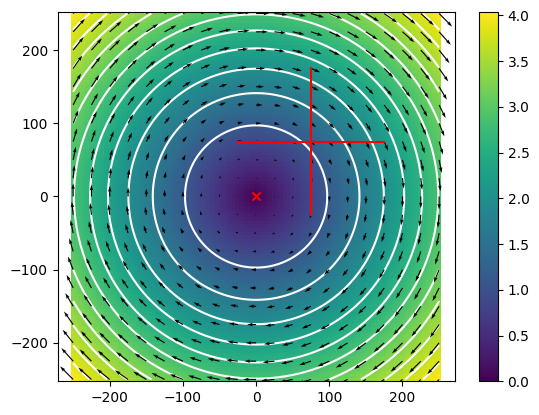

In [14]:
plt.pcolor(X_circ, Y_circ, np.hypot(u_circ, v_circ).T)
plt.colorbar()
levels = range(int(np.min(Psi_circ)), int(np.max(Psi_circ)), 60)
plt.contour(X_circ, Y_circ, Psi_circ, levels=levels, colors='w', linestyles='-')

spacing = 5
plt.quiver(X_circ[::spacing, ::spacing], Y_circ[::spacing, ::spacing],
             u_circ[::spacing, ::spacing].T, v_circ[::spacing, ::spacing].T, zorder=3, color='k')

plt.plot(x1_circ2, y1_circ2, 'r', zorder=4)
plt.plot(x2_circ2, y2_circ2, 'r', zorder=4)

plt.scatter(x0_circ2, y0_circ2, color='r', marker='x', zorder=4)

plt.axis('equal')

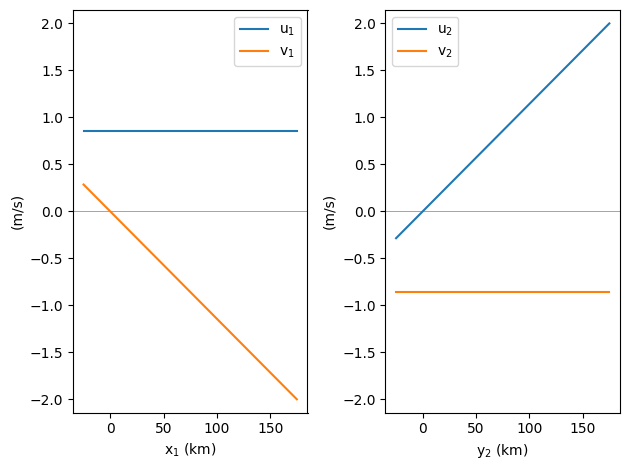

In [15]:
fig, axs = plt.subplots(1, 2)

axs[0].plot(x1_circ2, u1_circ2, label=r'u$_1$')
axs[0].plot(y2_circ2, v1_circ2, label=r'v$_1$')
axs[0].axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
axs[0].set_ylabel('(m/s)')
axs[0].set_xlabel(r'x$_1$ (km)')
axs[0].legend()


axs[1].plot(x1_circ2, u2_circ2, label=r'u$_2$')
axs[1].plot(y2_circ2, v2_circ2, label=r'v$_2$')
axs[1].axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
axs[1].set_ylabel('(m/s)')
axs[1].set_xlabel(r'y$_2$ (km)')
axs[1].legend()

ymin, ymax = min(ax.get_ylim()[0] for ax in axs), max(ax.get_ylim()[1] for ax in axs)
for ax in axs:
    ax.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()

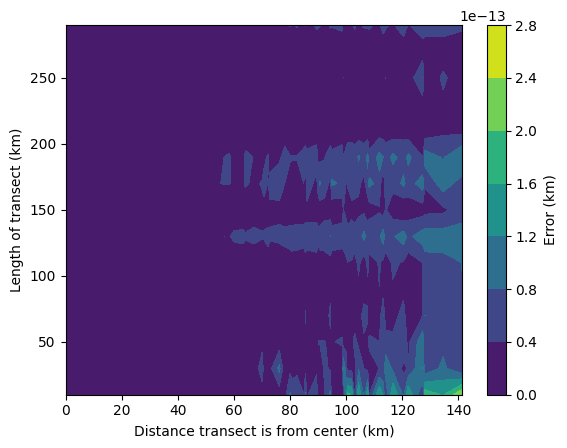

In [16]:
df_circ = pd.DataFrame(columns=['D', 'L', 'Error'])
r_max = 30
for i in range(u_circ.shape[0]//2, u_circ.shape[0] - r_max + 1, 2):
    for j in range(u_circ.shape[1]//2, u_circ.shape[1] - r_max + 1, 2):
        d = np.hypot(X_circ[i,j], Y_circ[i,j])
        for r in range(1, r_max + 1, 2):
            x0_test, y0_test, _ = moca2(i, j, r, u_circ, v_circ, X_circ, Y_circ)
            err = np.hypot(x0_test, y0_test)
            dx = x_circ[1] - x_circ[0]
            df_circ.loc[len(df_circ)] = {'D': d, 'L': 2*r*dx, 'Error': err}

df_agg = df_circ.groupby(['D', 'L'], as_index=False)['Error'].mean().copy()

D_circ2 = np.unique(df_agg['D'])
L_circ2 = np.unique(df_agg['L'])

# Create grid and reshape error values
D_circ2, L_circ2 = np.meshgrid(D_circ2, L_circ2)
Z_circ2 = df_agg.pivot(index='L', columns='D', values='Error').values

plt.contourf(D_circ2, L_circ2, Z_circ2)
plt.colorbar(label='Error (km)')
plt.xlabel('Distance transect is from center (km)')
plt.ylabel('Length of transect (km)')
plt.show()

#### Ellipse

In [17]:
r = 20

u1_ell2 = u_ell[nic-r:nic+r+1, njc]
v1_ell2 = v_ell[nic-r:nic+r+1, njc]

x1_ell2 = X_ell.T[nic-r:nic+r+1, njc]
y1_ell2 = Y_ell.T[nic-r:nic+r+1, njc]

xx_ell2 = x1_ell2 - X_ell.T[nic, njc]

u2_ell2 = u_ell[nic, njc-r:njc+r+1]
v2_ell2 = v_ell[nic, njc-r:njc+r+1]

x2_ell2 = X_ell.T[nic, njc-r:njc+r+1]
y2_ell2 = Y_ell.T[nic, njc-r:njc+r+1]

yy_ell2 = y2_ell2 - Y_ell.T[nic, njc]

def lin_fit(x, y):
    p = np.polyfit(x, y, 1)
    y_pred = np.polyval(p, x)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    ss_res = np.sum((y - y_pred) ** 2)
    r2 = 1.0 if ss_tot == 0 else 1 - ss_res / ss_tot
    return p[0], p[1], r2

A1, A0, r2A = lin_fit(xx_ell2, u1_ell2)
B1, B0, r2B = lin_fit(xx_ell2, v1_ell2)
C1, C0, r2C = lin_fit(yy_ell2, u2_ell2)
D1, D0, r2D = lin_fit(yy_ell2, v2_ell2)

alpha = A0 if r2A < r2B else C0
beta = B0 if r2B < r2D else D0
gamma = A1 if r2A < r2D else -D1
q11, q12, q22 = B1 / 2, -gamma / 2, -C1 / 2
# Q = np.array([[q11, q12], [q12, q22]])
x0_ell2 = (alpha * q12 + beta * q22) / (2 * (q12 ** 2 - q11 * q22))
y0_ell2 = (q11 * alpha + q12 * beta) / (2 * (q11 * q22 - q12 ** 2)) 
w_ell2 = 2 * (q11 + q22)

x0_ell2 += X_ell.T[nic, njc] 
y0_ell2 += Y_ell.T[nic, njc] 

print(x0_ell2, y0_ell2)

1.4210854715202004e-14 1.4210854715202004e-14


(np.float64(-252.5), np.float64(252.5), np.float64(-252.5), np.float64(252.5))

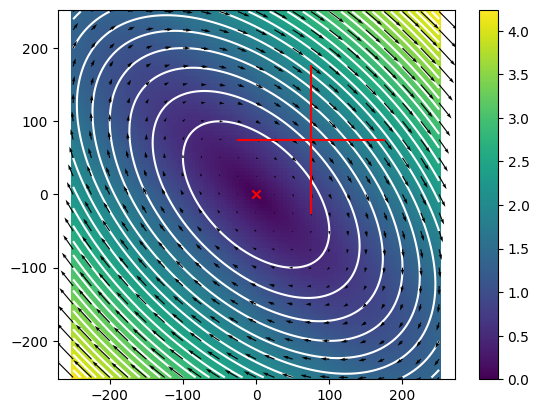

In [18]:
plt.pcolor(X_ell, Y_ell, np.hypot(u_ell, v_ell).T)
plt.colorbar()
levels = range(int(np.min(Psi_ell)), int(np.max(Psi_ell)), 30)
plt.contour(X_ell, Y_ell, Psi_ell, levels=levels, colors='w', linestyles='-')

spacing = 5
plt.quiver(X_ell[::spacing, ::spacing], Y_ell[::spacing, ::spacing],
             u_ell[::spacing, ::spacing].T, v_ell[::spacing, ::spacing].T, zorder=3)

plt.plot(x1_ell2, y1_ell2, 'r', zorder=4)
plt.plot(x2_ell2, y2_ell2, 'r', zorder=4)

plt.scatter(x0_ell2, y0_ell2, color='r', marker='x', zorder=4)

plt.axis('equal')

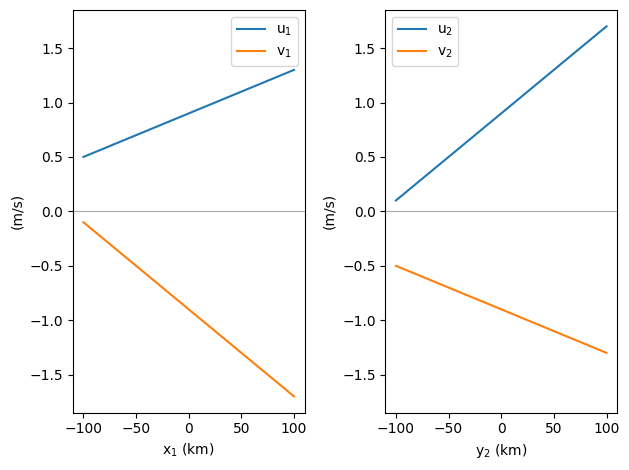

In [19]:
fig, axs = plt.subplots(1, 2)

axs[0].plot(xx_ell2, u1_ell2, label=r'u$_1$')
axs[0].plot(xx_ell2, v1_ell2, label=r'v$_1$')
axs[0].axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
axs[0].set_ylabel('(m/s)')
axs[0].set_xlabel(r'x$_1$ (km)')
axs[0].legend()


axs[1].plot(yy_ell2, u2_ell2, label=r'u$_2$')
axs[1].plot(yy_ell2, v2_ell2, label=r'v$_2$')
axs[1].axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
axs[1].set_ylabel('(m/s)')
axs[1].set_xlabel(r'y$_2$ (km)')
axs[1].legend()

ymin, ymax = min(ax.get_ylim()[0] for ax in axs), max(ax.get_ylim()[1] for ax in axs)
for ax in axs:
    ax.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()

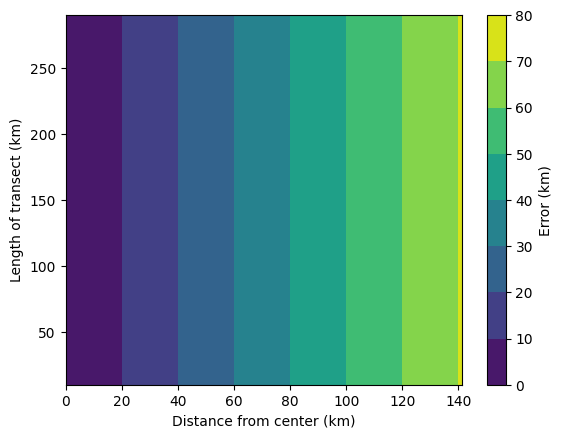

In [20]:
df_ell = pd.DataFrame(columns=['D', 'L', 'Error'])
r_max = 30
for i in range(r_max, u_ell.shape[0] - r_max + 1, 2):
    for j in range(u_ell.shape[1]//2, u_ell.shape[1] - r_max + 1, 2):
        d = np.hypot(X_ell[i,j], Y_ell[i,j])
        for r in range(1, r_max + 1, 2):
            x0_test, y0_test, _ = moca2(i, j, r, u_ell, v_ell, X_ell, Y_ell)
            err = np.hypot(x0_test, y0_test)
            df_ell.loc[len(df_ell)] = {'D': d, 'L': 2*r, 'Error': err}

df_agg = df_ell.groupby(['D', 'L'], as_index=False)['Error'].mean().copy()

D_ell2 = np.unique(df_agg['D'])
L_ell2 = np.unique(df_agg['L'])

# Create grid and reshape error values
D_ell2, L_ell2 = np.meshgrid(D_ell2, L_ell2)
Z_ell2 = df_agg.pivot(index='L', columns='D', values='Error').values

plt.contourf(D_ell, L_ell, Z_ell)
plt.colorbar(label='Error (km)')
plt.xlabel('Distance from center (km)')
plt.ylabel('Length of transect (km)')
plt.show()

#### Paper Plot

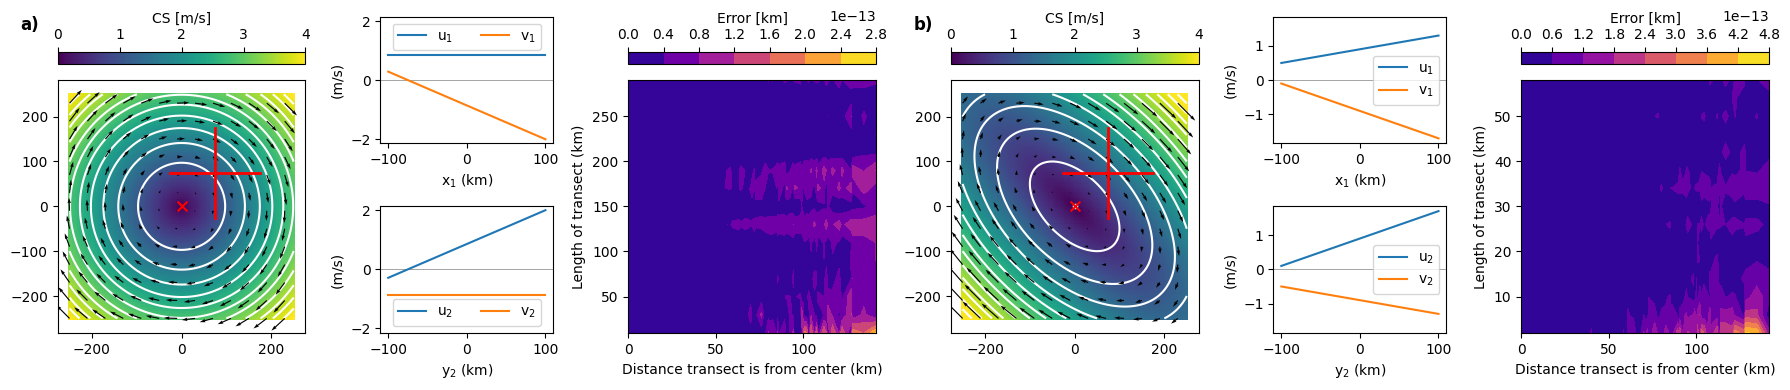

In [21]:
import matplotlib.gridspec as gridspec


fig = plt.figure(figsize=(18, 4))
spacing = 8
gs = gridspec.GridSpec(2, 10, figure=fig, width_ratios=[1, 1, 2, 1, 1, 1, 1, 2, 1, 1])  # Adjust width ratios

# LEFT PLOT (PLOT A)
ax_main_left = fig.add_subplot(gs[:, :2])
pcm = ax_main_left.pcolor(X_circ, Y_circ, np.hypot(u_circ, v_circ).T, vmin=0, vmax=4)
cbar = fig.colorbar(pcm, ax=ax_main_left, orientation='horizontal', location='top', label='CS [m/s]')
levels = range(int(np.min(Psi_circ)), int(np.max(Psi_circ)), 60)
ax_main_left.contour(X_circ, Y_circ, Psi_circ, levels=levels, colors='w', linestyles='-')
ax_main_left.quiver(X_circ[::spacing, ::spacing], Y_circ[::spacing, ::spacing],
            u_circ[::spacing, ::spacing].T, v_circ[::spacing, ::spacing].T, zorder=3)

ax_main_left.plot(x1_circ2, y1_circ2, 'r', linewidth=2, zorder=3)
ax_main_left.plot(x2_circ2, y2_circ2, 'r', linewidth=2, zorder=3)


ax_main_right.scatter(0, 0, color='w', marker='.')
ax_main_left.scatter(x0_circ2, y0_circ2, color='r', marker='x', s=50, zorder=4)
ax_main_left.axis('equal')
ax_main_left.text(-0.15, 1.20, 'a)', transform=ax_main_left.transAxes, fontsize=12, fontweight='bold')

# Subplot columns (2x1 on the right)
ax2_left = fig.add_subplot(gs[0, 2])
ax3_left = fig.add_subplot(gs[1, 2])

ax2_left.plot(xx_circ2, u1_circ2, label=r'u$_1$')
ax2_left.plot(xx_circ2, v1_circ2, label=r'v$_1$')
ax2_left.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax2_left.set_ylabel('(m/s)')
ax2_left.set_xlabel(r'x$_1$ (km)')
ax2_left.legend(loc='upper center', ncol=2)

ax3_left.plot(yy_circ2, u2_circ2, label=r'u$_2$')
ax3_left.plot(yy_circ2, v2_circ2, label=r'v$_2$')
ax3_left.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax3_left.set_ylabel('(m/s)')
ax3_left.set_xlabel(r'y$_2$ (km)')
ax3_left.legend(loc='lower center', ncol=2)

axs = [ax2_left, ax3_left]
ymin, ymax = min(ax.get_ylim()[0] for ax in axs), max(ax.get_ylim()[1] for ax in axs)
for ax in axs:
    ax.set_ylim(ymin, ymax)

# Left error 
ax_error_left = fig.add_subplot(gs[:, 3:5])
ctf = ax_error_left.contourf(D_circ2, L_circ2, Z_circ2, cmap='plasma')
cbar = fig.colorbar(ctf, ax=ax_error_left, orientation='horizontal', location='top', label='Error [km]')
ax_error_left.set_xlabel('Distance transect is from center (km)')
ax_error_left.set_ylabel('Length of transect (km)')

# RIGHT PLOT (PLOT B)
ax_main_right = fig.add_subplot(gs[:, 5:7])
pcm = ax_main_right.pcolor(X_ell, Y_ell, np.hypot(u_ell, v_ell).T, vmin=0, vmax=4)
cbar = fig.colorbar(pcm, ax=ax_main_right, orientation='horizontal', location='top', label='CS [m/s]')
levels = range(int(np.min(Psi_ell)), int(np.max(Psi_ell)), 60)
ax_main_right.contour(X_ell, Y_ell, Psi_ell, levels=levels, colors='w', linestyles='-')
ax_main_right.quiver(X_ell[::spacing, ::spacing], Y_ell[::spacing, ::spacing],
             u_ell[::spacing, ::spacing].T, v_ell[::spacing, ::spacing].T, zorder=3)

ax_main_right.plot(x1_ell2, y1_ell2, 'r', linewidth=2, zorder=3)
ax_main_right.plot(x2_ell2, y2_ell2, 'r', linewidth=2, zorder=3)

ax_main_right.scatter(0, 0, color='w', marker='.')
ax_main_right.scatter(x0_ell2, y0_ell2, color='r', marker='x', s=50, zorder=4)
ax_main_right.axis('equal')
ax_main_right.text(-0.15, 1.20, 'b)', transform=ax_main_right.transAxes, fontsize=12, fontweight='bold')

# Subplot columns (2x1 on the right)
ax2_right = fig.add_subplot(gs[0, 7])
ax3_right = fig.add_subplot(gs[1, 7])

ax2_right.plot(xx_ell2, u1_ell2, label=r'u$_1$')
ax2_right.plot(xx_ell2, v1_ell2, label=r'v$_1$')
ax2_right.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax2_right.set_ylabel('(m/s)')
ax2_right.set_xlabel(r'x$_1$ (km)')
ax2_right.legend(loc='center right')
ax3_right.plot(yy_ell2, u2_ell2, label=r'u$_2$')
ax3_right.plot(yy_ell2, v2_ell2, label=r'v$_2$')
ax3_right.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax3_right.set_ylabel('(m/s)')
ax3_right.set_xlabel(r'y$_2$ (km)')
ax3_right.legend(loc='center right')

axs = [ax2_right, ax3_right]
ymin, ymax = min(ax.get_ylim()[0] for ax in axs), max(ax.get_ylim()[1] for ax in axs)
for ax in axs:
    ax.set_ylim(ymin, ymax)

# Right error 
ax_error_right = fig.add_subplot(gs[:, 8:10])
ctf = ax_error_right.contourf(D_ell2, L_ell2, Z_ell2, cmap='plasma')
cbar = fig.colorbar(ctf, ax=ax_error_right, orientation='horizontal', location='top', label='Error [km]')
ax_error_right.set_xlabel('Distance transect is from center (km)')
ax_error_right.set_ylabel('Length of transect (km)')

plt.tight_layout()
plt.show()

## Final Plot

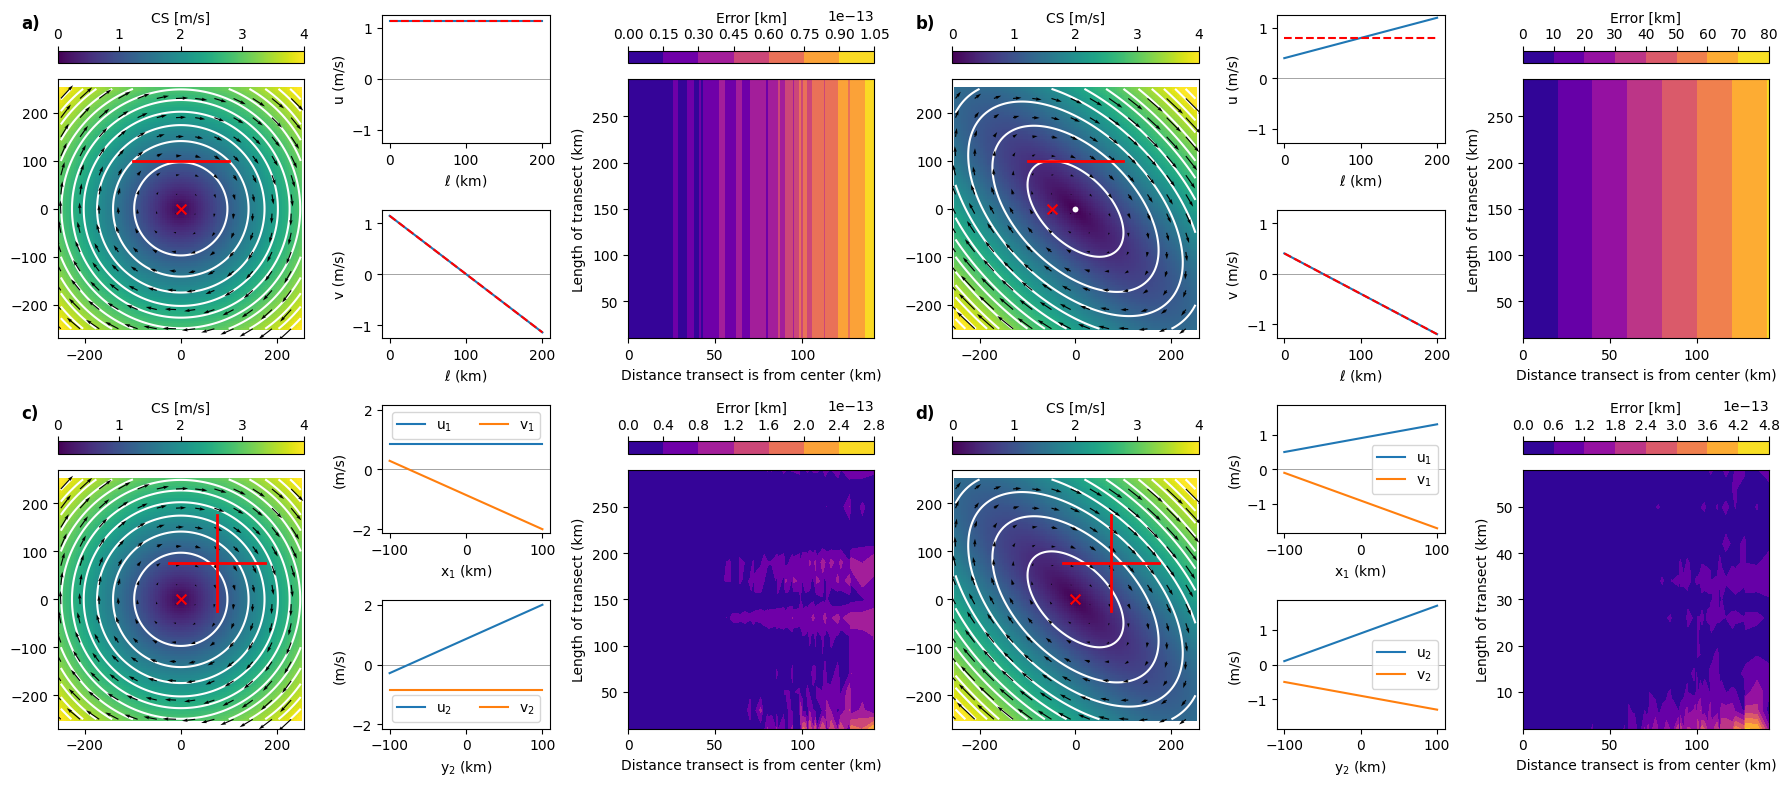

In [22]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(18, 8))
gs = gridspec.GridSpec(4, 10, figure=fig, width_ratios=[1, 1, 2, 1, 1, 1, 1, 2, 1, 1]) 

##### 2 #####

#1 LEFT PLOT (PLOT A)
ax_main_left = fig.add_subplot(gs[:2, :2])
pcm = ax_main_left.pcolor(X_circ, Y_circ, np.hypot(u_circ, v_circ).T, vmin=0, vmax=4)
cbar = fig.colorbar(pcm, ax=ax_main_left, orientation='horizontal', location='top', label='CS [m/s]')
levels = range(int(np.min(Psi_circ)), int(np.max(Psi_circ)), 60)
ax_main_left.contour(X_circ, Y_circ, Psi_circ, levels=levels, colors='w', linestyles='-')
ax_main_left.quiver(X_circ[::spacing, ::spacing], Y_circ[::spacing, ::spacing],
            u_circ[::spacing, ::spacing].T, v_circ[::spacing, ::spacing].T, zorder=3)
ax_main_left.plot(xx_circ, yy_circ, 'r', linewidth=2, zorder=3)
# ax_main_left.scatter(0, 0, color='w', marker='.')
ax_main_left.scatter(x0_circ, y0_circ, color='r', marker='x', s=50, zorder=4)
ax_main_left.axis('equal')
ax_main_left.text(-0.15, 1.20, 'a)', transform=ax_main_left.transAxes, fontsize=12, fontweight='bold')

#1 Subplot columns (2x1 on the right)
ax2_left = fig.add_subplot(gs[0, 2])
ax3_left = fig.add_subplot(gs[1, 2])

axs = [ax2_left, ax3_left]
for ax, data, ylabel, p in zip(axs, [u1_circ, v1_circ], ['u (m/s)', 'v (m/s)'], [0, 1]):
    ax.plot(l_circ, data)
    ax.plot(l_circ, np.poly1d(np.polyfit(l_circ, data, p))(l_circ), "--r")
    ax.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(r'$\ell$ (km)')
ymin, ymax = min(ax.get_ylim()[0] for ax in axs), max(ax.get_ylim()[1] for ax in axs)
for ax in axs:
    ax.set_ylim(ymin, ymax)

#1 Left error 
ax_error_left = fig.add_subplot(gs[:2, 3:5])
ctf = ax_error_left.contourf(D_circ, L_circ, Z_circ, cmap='plasma')
cbar = fig.colorbar(ctf, ax=ax_error_left, orientation='horizontal', location='top', label='Error [km]')
ax_error_left.set_xlabel('Distance transect is from center (km)')
ax_error_left.set_ylabel('Length of transect (km)')

#1 RIGHT PLOT (PLOT B)
ax_main_right = fig.add_subplot(gs[:2, 5:7])
pcm = ax_main_right.pcolor(X_ell, Y_ell, np.hypot(u_ell, v_ell).T, vmin=0, vmax=4)
cbar = fig.colorbar(pcm, ax=ax_main_right, orientation='horizontal', location='top', label='CS [m/s]')
levels = range(int(np.min(Psi_ell)), int(np.max(Psi_ell)), 60)
ax_main_right.contour(X_ell, Y_ell, Psi_ell, levels=levels, colors='w', linestyles='-')
ax_main_right.quiver(X_ell[::spacing, ::spacing], Y_ell[::spacing, ::spacing],
             u_ell[::spacing, ::spacing].T, v_ell[::spacing, ::spacing].T, zorder=3)
ax_main_right.plot(xx_ell, yy_ell, 'r', linewidth=2, zorder=3)
ax_main_right.scatter(0, 0, color='w', marker='.')
ax_main_right.scatter(x0_ell, y0_ell, color='r', marker='x', s=50, zorder=4)
ax_main_right.axis('equal')
ax_main_right.text(-0.15, 1.20, 'b)', transform=ax_main_right.transAxes, fontsize=12, fontweight='bold')

#1 Subplot columns (2x1 on the right)
ax2_right = fig.add_subplot(gs[0, 7])
ax3_right = fig.add_subplot(gs[1, 7])

axs = [ax2_right, ax3_right]
for ax, data, ylabel, p in zip(axs, [u1_ell, v1_ell], ['u (m/s)', 'v (m/s)'], [0, 1]):
    ax.plot(l_ell, data)
    ax.plot(l_ell, np.poly1d(np.polyfit(l_ell, data, p))(l_ell), "--r")
    ax.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(r'$\ell$ (km)')
ymin, ymax = min(ax.get_ylim()[0] for ax in axs), max(ax.get_ylim()[1] for ax in axs)
for ax in axs:
    ax.set_ylim(ymin, ymax)

#1 Right error 
ax_error_right = fig.add_subplot(gs[:2, 8:10])
ctf = ax_error_right.contourf(D_ell, L_ell, Z_ell, cmap='plasma')
cbar = fig.colorbar(ctf, ax=ax_error_right, orientation='horizontal', location='top', label='Error [km]')
ax_error_right.set_xlabel('Distance transect is from center (km)')
ax_error_right.set_ylabel('Length of transect (km)')

##### 2 #####

#2 LEFT PLOT (PLOT A)
ax_main_left = fig.add_subplot(gs[2:, :2])
pcm = ax_main_left.pcolor(X_circ, Y_circ, np.hypot(u_circ, v_circ).T, vmin=0, vmax=4)
cbar = fig.colorbar(pcm, ax=ax_main_left, orientation='horizontal', location='top', label='CS [m/s]')
levels = range(int(np.min(Psi_circ)), int(np.max(Psi_circ)), 60)
ax_main_left.contour(X_circ, Y_circ, Psi_circ, levels=levels, colors='w', linestyles='-')
ax_main_left.quiver(X_circ[::spacing, ::spacing], Y_circ[::spacing, ::spacing],
            u_circ[::spacing, ::spacing].T, v_circ[::spacing, ::spacing].T, zorder=3)
ax_main_left.plot(x1_circ2, y1_circ2, 'r', linewidth=2, zorder=3)
ax_main_left.plot(x2_circ2, y2_circ2, 'r', linewidth=2, zorder=3)
ax_main_right.scatter(0, 0, color='w', marker='.')
ax_main_left.scatter(x0_circ2, y0_circ2, color='r', marker='x', s=50, zorder=4)
ax_main_left.axis('equal')
ax_main_left.text(-0.15, 1.20, 'c)', transform=ax_main_left.transAxes, fontsize=12, fontweight='bold')

#2 Subplot columns (2x1 on the right)
ax2_left = fig.add_subplot(gs[2, 2])
ax3_left = fig.add_subplot(gs[3, 2])

ax2_left.plot(xx_circ2, u1_circ2, label=r'u$_1$')
ax2_left.plot(xx_circ2, v1_circ2, label=r'v$_1$')
ax2_left.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax2_left.set_ylabel('(m/s)')
ax2_left.set_xlabel(r'x$_1$ (km)')
ax2_left.legend(loc='upper center', ncol=2)
ax3_left.plot(yy_circ2, u2_circ2, label=r'u$_2$')
ax3_left.plot(yy_circ2, v2_circ2, label=r'v$_2$')
ax3_left.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax3_left.set_ylabel('(m/s)')
ax3_left.set_xlabel(r'y$_2$ (km)')
ax3_left.legend(loc='lower center', ncol=2)

axs = [ax2_left, ax3_left]
ymin, ymax = min(ax.get_ylim()[0] for ax in axs), max(ax.get_ylim()[1] for ax in axs)
for ax in axs:
    ax.set_ylim(ymin, ymax)

#2 Left error 
ax_error_left = fig.add_subplot(gs[2:, 3:5])
ctf = ax_error_left.contourf(D_circ2, L_circ2, Z_circ2, cmap='plasma')
cbar = fig.colorbar(ctf, ax=ax_error_left, orientation='horizontal', location='top', label='Error [km]')
ax_error_left.set_xlabel('Distance transect is from center (km)')
ax_error_left.set_ylabel('Length of transect (km)')

#2 RIGHT PLOT (PLOT B)
ax_main_right = fig.add_subplot(gs[2:, 5:7])
pcm = ax_main_right.pcolor(X_ell, Y_ell, np.hypot(u_ell, v_ell).T, vmin=0, vmax=4)
cbar = fig.colorbar(pcm, ax=ax_main_right, orientation='horizontal', location='top', label='CS [m/s]')
levels = range(int(np.min(Psi_ell)), int(np.max(Psi_ell)), 60)
ax_main_right.contour(X_ell, Y_ell, Psi_ell, levels=levels, colors='w', linestyles='-')
ax_main_right.quiver(X_ell[::spacing, ::spacing], Y_ell[::spacing, ::spacing],
             u_ell[::spacing, ::spacing].T, v_ell[::spacing, ::spacing].T, zorder=3)
ax_main_right.plot(x1_ell2, y1_ell2, 'r', linewidth=2, zorder=3)
ax_main_right.plot(x2_ell2, y2_ell2, 'r', linewidth=2, zorder=3)
# ax_main_right.scatter(0, 0, color='w', marker='.')
ax_main_right.scatter(x0_ell2, y0_ell2, color='r', marker='x', s=50, zorder=4)
ax_main_right.axis('equal')
ax_main_right.text(-0.15, 1.20, 'd)', transform=ax_main_right.transAxes, fontsize=12, fontweight='bold')

#2 Subplot columns (2x1 on the right)
ax2_right = fig.add_subplot(gs[2, 7])
ax3_right = fig.add_subplot(gs[3, 7])

ax2_right.plot(xx_ell2, u1_ell2, label=r'u$_1$')
ax2_right.plot(xx_ell2, v1_ell2, label=r'v$_1$')
ax2_right.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax2_right.set_ylabel('(m/s)')
ax2_right.set_xlabel(r'x$_1$ (km)')
ax2_right.legend(loc='center right')
ax3_right.plot(yy_ell2, u2_ell2, label=r'u$_2$')
ax3_right.plot(yy_ell2, v2_ell2, label=r'v$_2$')
ax3_right.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax3_right.set_ylabel('(m/s)')
ax3_right.set_xlabel(r'y$_2$ (km)')
ax3_right.legend(loc='center right')

axs = [ax2_right, ax3_right]
ymin, ymax = min(ax.get_ylim()[0] for ax in axs), max(ax.get_ylim()[1] for ax in axs)
for ax in axs:
    ax.set_ylim(ymin, ymax)

#2 Right error 
ax_error_right = fig.add_subplot(gs[2:, 8:10])
ctf = ax_error_right.contourf(D_ell2, L_ell2, Z_ell2, cmap='plasma')
cbar = fig.colorbar(ctf, ax=ax_error_right, orientation='horizontal', location='top', label='Error [km]')
ax_error_right.set_xlabel('Distance transect is from center (km)')
ax_error_right.set_ylabel('Length of transect (km)')

plt.tight_layout()
plt.show()


## Results

